In [1]:
import sys, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

# print(os.listdir("./"))
pd.set_option('display.max_columns', None)

from collections import Counter 
from collections import defaultdict
import itertools


In [22]:
# !python -m pip install scikit-learn --user --upgrade pip

In [2]:
df = pd.read_csv('./survey_results_public.csv')
df.head(5)

Respondent                                       Professional  \
0           1                                            Student   
1           2                                            Student   
2           3                             Professional developer   
3           4  Professional non-developer who sometimes write...   
4           5                             Professional developer   

                ProgramHobby         Country      University  \
0                  Yes, both   United States              No   
1                  Yes, both  United Kingdom  Yes, full-time   
2                  Yes, both  United Kingdom              No   
3                  Yes, both   United States              No   
4  Yes, I program as a hobby     Switzerland              No   

                         EmploymentStatus  \
0  Not employed, and not looking for work   
1                      Employed part-time   
2                      Employed full-time   
3                      Employed full-time   
4                      Employed full-time   

                                     FormalEducation  \
0                                   Secondary school   
1  Some college/university study without earning ...   
2                                  Bachelor's degree   
3                                    Doctoral degree   
4                                    Master's degree   

                                  MajorUndergrad  \
0                                            NaN   
1       Computer science or software engineering   
2       Computer science or software engineering   
3  A non-computer-focused engineering discipline   
4       Computer science or software engineering   

                                          HomeRemote  \
0                                                NaN   
1              More than half, but not all, the time   
2  Less than half the time, but at least one day ...   
3  Less than half the time, but at least one day ...   
4                                              Never   

                CompanySize  \
0                       NaN   
1        20 to 99 employees   
2  10,000 or more employees   
3  10,000 or more employees   
4        10 to 19 employees   

                                         CompanyType      YearsProgram  \
0                                                NaN      2 to 3 years   
1  Privately-held limited company, not in startup...     9 to 10 years   
2                        Publicly-traded corporation  20 or more years   
3  Non-profit/non-governmental organization or pr...    14 to 15 years   
4  Privately-held limited company, not in startup...  20 or more years   

      YearsCodedJob YearsCodedJobPast  \
0               NaN               NaN   
1               NaN               NaN   
2  20 or more years               NaN   
3     9 to 10 years               NaN   
4    10 to 11 years               NaN   

                                       DeveloperType WebDeveloperType  \
0                                                NaN              NaN   
1                                                NaN              NaN   
2                                              Other              NaN   
3                                                NaN              NaN   
4  Mobile developer; Graphics programming; Deskto...              NaN   

  MobileDeveloperType NonDeveloperType  CareerSatisfaction  JobSatisfaction  \
0                 NaN              NaN                 NaN              NaN   
1                 NaN              NaN                 NaN              NaN   
2                 NaN              NaN                 8.0              9.0   
3                 NaN   Data scientist                 6.0              3.0   
4                 NaN              NaN                 6.0              8.0   

  ExCoderReturn ExCoderNotForMe ExCoderBalance ExCoder10Years ExCoderBelonged  \
0           NaN             NaN            NaN            NaN             NaN

In [3]:
df.shape

(19102, 154)

In [4]:
schDf = pd.read_csv('./survey_results_schema.csv')
schDf.head(10)

Column                                           Question
0        Respondent                               Respondent ID number
1      Professional         Which of the following best describes you?
2      ProgramHobby  Do you program as a hobby or contribute to ope...
3           Country            In which country do you currently live?
4        University  Are you currently enrolled in a formal, degree...
5  EmploymentStatus  Which of the following best describes your cur...
6   FormalEducation  Which of the following best describes the high...
7    MajorUndergrad  Which of the following best describes your mai...
8        HomeRemote       How often do you work from home or remotely?
9       CompanySize  In terms of the number of employees, how large...

In [5]:
schDf.shape

(154, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19102 entries, 0 to 19101
Columns: 154 entries, Respondent to ExpectedSalary
dtypes: float64(6), int64(1), object(147)
memory usage: 22.4+ MB


In [7]:
schDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 2 columns):
Column      154 non-null object
Question    154 non-null object
dtypes: object(2)
memory usage: 2.5+ KB


# PREDICTION

In [8]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = True)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = True)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


In [9]:
labelDf=df.copy().drop(["ExpectedSalary", "Respondent"], axis=1)

fitting numeric NaN vals based on other columns...

In [10]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

cat_vars = labelDf.select_dtypes(include=['object']).copy().columns
num_vars = labelDf.select_dtypes(include=['float', 'int']).copy().columns

imp = IterativeImputer(max_iter=10, random_state=0)

impDf = labelDf[labelDf["Salary"].isnull()==False].reset_index().copy()
imp.fit(impDf[num_vars])
impDf[num_vars]=pd.DataFrame(data=imp.transform(impDf[num_vars]), columns=num_vars)


In [11]:
impFinDf= impDf.copy().drop("index", axis=1)

rounding fitted numeric columns to nearest integer

In [12]:
for i in impFinDf.select_dtypes(include=['float', 'int']).columns:
    if i != "Salary":
        impFinDf[i] = impFinDf[i].apply(lambda x: round(x))

In [13]:
impFinDf.head(2)

Professional               ProgramHobby         Country  \
0  Professional developer                  Yes, both  United Kingdom   
1  Professional developer  Yes, I program as a hobby  United Kingdom   

  University    EmploymentStatus      FormalEducation  \
0         No  Employed full-time    Bachelor's degree   
1         No  Employed full-time  Professional degree   

                                      MajorUndergrad  \
0           Computer science or software engineering   
1  Computer engineering or electrical/electronics...   

                                          HomeRemote  \
0  Less than half the time, but at least one day ...   
1  All or almost all the time (I'm full-time remote)   

                CompanySize                  CompanyType      YearsProgram  \
0  10,000 or more employees  Publicly-traded corporation  20 or more years   
1  5,000 to 9,999 employees  Publicly-traded corporation  20 or more years   

      YearsCodedJob YearsCodedJobPast  \
0  20 or more years               NaN   
1  20 or more years               NaN   

                             DeveloperType WebDeveloperType  \
0                                    Other              NaN   
1  Embedded applications/devices developer              NaN   

  MobileDeveloperType NonDeveloperType  CareerSatisfaction  JobSatisfaction  \
0                 NaN              NaN                   8                9   
1                 NaN              NaN                   8                8   

  ExCoderReturn ExCoderNotForMe ExCoderBalance ExCoder10Years ExCoderBelonged  \
0           NaN             NaN            NaN            NaN             NaN   
1           NaN             NaN            NaN            NaN             NaN   

  ExCoderSkills ExCoderWillNotCode ExCoderActive  \
0           NaN                NaN           NaN   
1           NaN                NaN           NaN   

                   PronounceGIF  ProblemSolving  BuildingThings  \
0  With a hard "g," like "gift"  Strongly agree  Strongly agree   
1  With a hard "g," like "gift"  Strongly agree  Strongly agree   

  LearningNewTech   BoringDetails     JobSecurity DiversityImportant  \
0  Strongly agree  Somewhat agree           Agree     Strongly agree   
1           Agree        Disagree  Somewhat agree     Somewhat agree   

       AnnoyingUI FriendsDevelopers   RightWrongWay UnderstandComputers  \
0           Agree    Somewhat agree        Disagree            Disagree   
1  Strongly agree    Somewhat agree  Somewhat agree            Disagree   

  SeriousWork InvestTimeTools WorkPayCare KinshipDevelopers ChallengeMyself  \
0       Agree  Somewhat agree    Disagree    Somewhat agree           Agree   
1       Agree           Agree    Disagree    Somewhat agree           Agree   

     CompetePeers     ChangeWorld JobSeekingStatus  HoursPerWeek LastNewJob  \
0        Disagree           Agree              NaN             1        NaN   
1  Somewhat agree  Somewhat agree              NaN             1        NaN   

  AssessJobIndustry AssessJobRole AssessJobExp AssessJobDept AssessJobTech  \
0               NaN           NaN          NaN           NaN           NaN   
1               NaN           NaN          NaN           NaN           NaN   

  AssessJobProjects AssessJobCompensation AssessJobOffice AssessJobCommute  \
0               NaN                   NaN             NaN              NaN   
1               NaN                   NaN             NaN              NaN   

  AssessJobRemote AssessJobLeaders AssessJobProfDevel AssessJobDiversity  \
0             NaN              NaN                NaN                NaN   
1             NaN              NaN                NaN                NaN   

  AssessJobProduct AssessJobFinances ImportantBenefits ClickyKeys JobProfile  \
0              NaN               NaN               NaN        Yes        NaN   
1              NaN               NaN               NaN         No   LinkedIn   

             ResumePrompted          

In [14]:
cols=['Professional', 'Country', 'University', 'EmploymentStatus', 'FormalEducation', 'MajorUndergrad', 'CompanyType', 'CompanySize', 'YearsProgram', 'YearsCodedJob', 'DeveloperType', 'JobSatisfaction', 'Overpaid', 'Gender', 'Race', 'Salary', 'HoursPerWeek', 'HomeRemote', 'WorkPayCare', 'ChallengeMyself', 'ChangeWorld', 'JobSeekingStatus']

In [15]:
cat_vars = impFinDf[cols].select_dtypes(include=['object']).copy().columns

for var in  cat_vars:
    impFinDf = pd.concat([impFinDf.drop(var, axis=1), pd.get_dummies(impFinDf[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

In [16]:
labelFinDf=impFinDf.corr()
labelFinDf

CareerSatisfaction  \
CareerSatisfaction                                            1.000000   
JobSatisfaction                                               0.603445   
HoursPerWeek                                                 -0.059849   
StackOverflowSatisfaction                                     0.157764   
Salary                                                        0.149544   
Country_Albania                                              -0.002894   
Country_Argentina                                             0.001984   
Country_Armenia                                              -0.000575   
Country_Australia                                            -0.007422   
Country_Austria                                              -0.020050   
Country_Azerbaidjan                                           0.020456   
Country_Bangladesh                                           -0.027817   
Country_Belarus                                              -0.009923   
Country_Belgium                                              -0.011235   
Country_Bermuda                                              -0.004436   
Country_Bosnia-Herzegovina                                    0.001213   
Country_Brazil                                               -0.018932   
Country_Bulgaria                                             -0.007656   
Country_Canada                                                0.057727   
Country_Chile                                                -0.017268   
Country_China                                                -0.018555   
Country_Colombia                                              0.031478   
Country_Costa Rica                                            0.003861   
Country_Croatia                                               0.016687   
Country_Cyprus                                                0.017197   
Country_Czech Republic                                       -0.003847   
Country_Denmark                                               0.023199   
Country_Dominican Republic                                    0.016025   
Country_Ecuador                                               0.016272   
Country_Egypt                                                -0.018009   
...                                                                ...   
Race_Middle Eastern                                          -0.003153   
Race_Middle Eastern; I don’t know                            -0.004436   
Race_Middle Eastern; White or of European descent             0.013614   
Race_Native American, Pacific Islander, or Indi...           -0.011414   
Race_Native American, Pacific Islander, or Indi...           -0.004494   
Race_South Asian                                             -0.049995   
Race_South Asian; White or of European descent                0.012350   
Race_White or of European descent                             0.047973   
Race_White or of European descent; I don’t know               0.030646   
Race_White or of European descent; I don’t know...           -0.004436   
HomeRemote_About half the time                                0.028886   
HomeRemote_All or almost all the time (I'm full...            0.065894   
HomeRemote_It's complicated                                  -0.003537   
HomeRemote_Less than half the time, but at leas...            0.041509   
HomeRemote_More than half, but not all, the time              0.014672   
HomeRemote_Never                                             -0.112924   
WorkPayCare_Disagree                                         -0.003308   
WorkPayCare_Somewhat agree                                   -0.018212   
WorkPayCare_Strongly agree                                    0.007660   
WorkPayCare_Strongly disagree                                 0.041246   
ChallengeMyself_Disagree                                     -0.045138   
ChallengeMyself_Somewhat agree                               -0.067300   
ChallengeMyself_Strongly agree                          

In [17]:
targets = labelFinDf[(labelFinDf.Salary<=-0.04)|(labelFinDf.Salary>=0.04)].reset_index()["index"].tolist()

In [18]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

X =  impFinDf[targets].drop('Salary',axis=1)
y =  impFinDf["Salary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)


In [19]:
lm_model= LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)

predictions=lm_model.predict(X_test)

In [20]:
from sklearn import metrics
print('R2:', metrics.r2_score(y_test, predictions))

R2: 0.7266931026110112


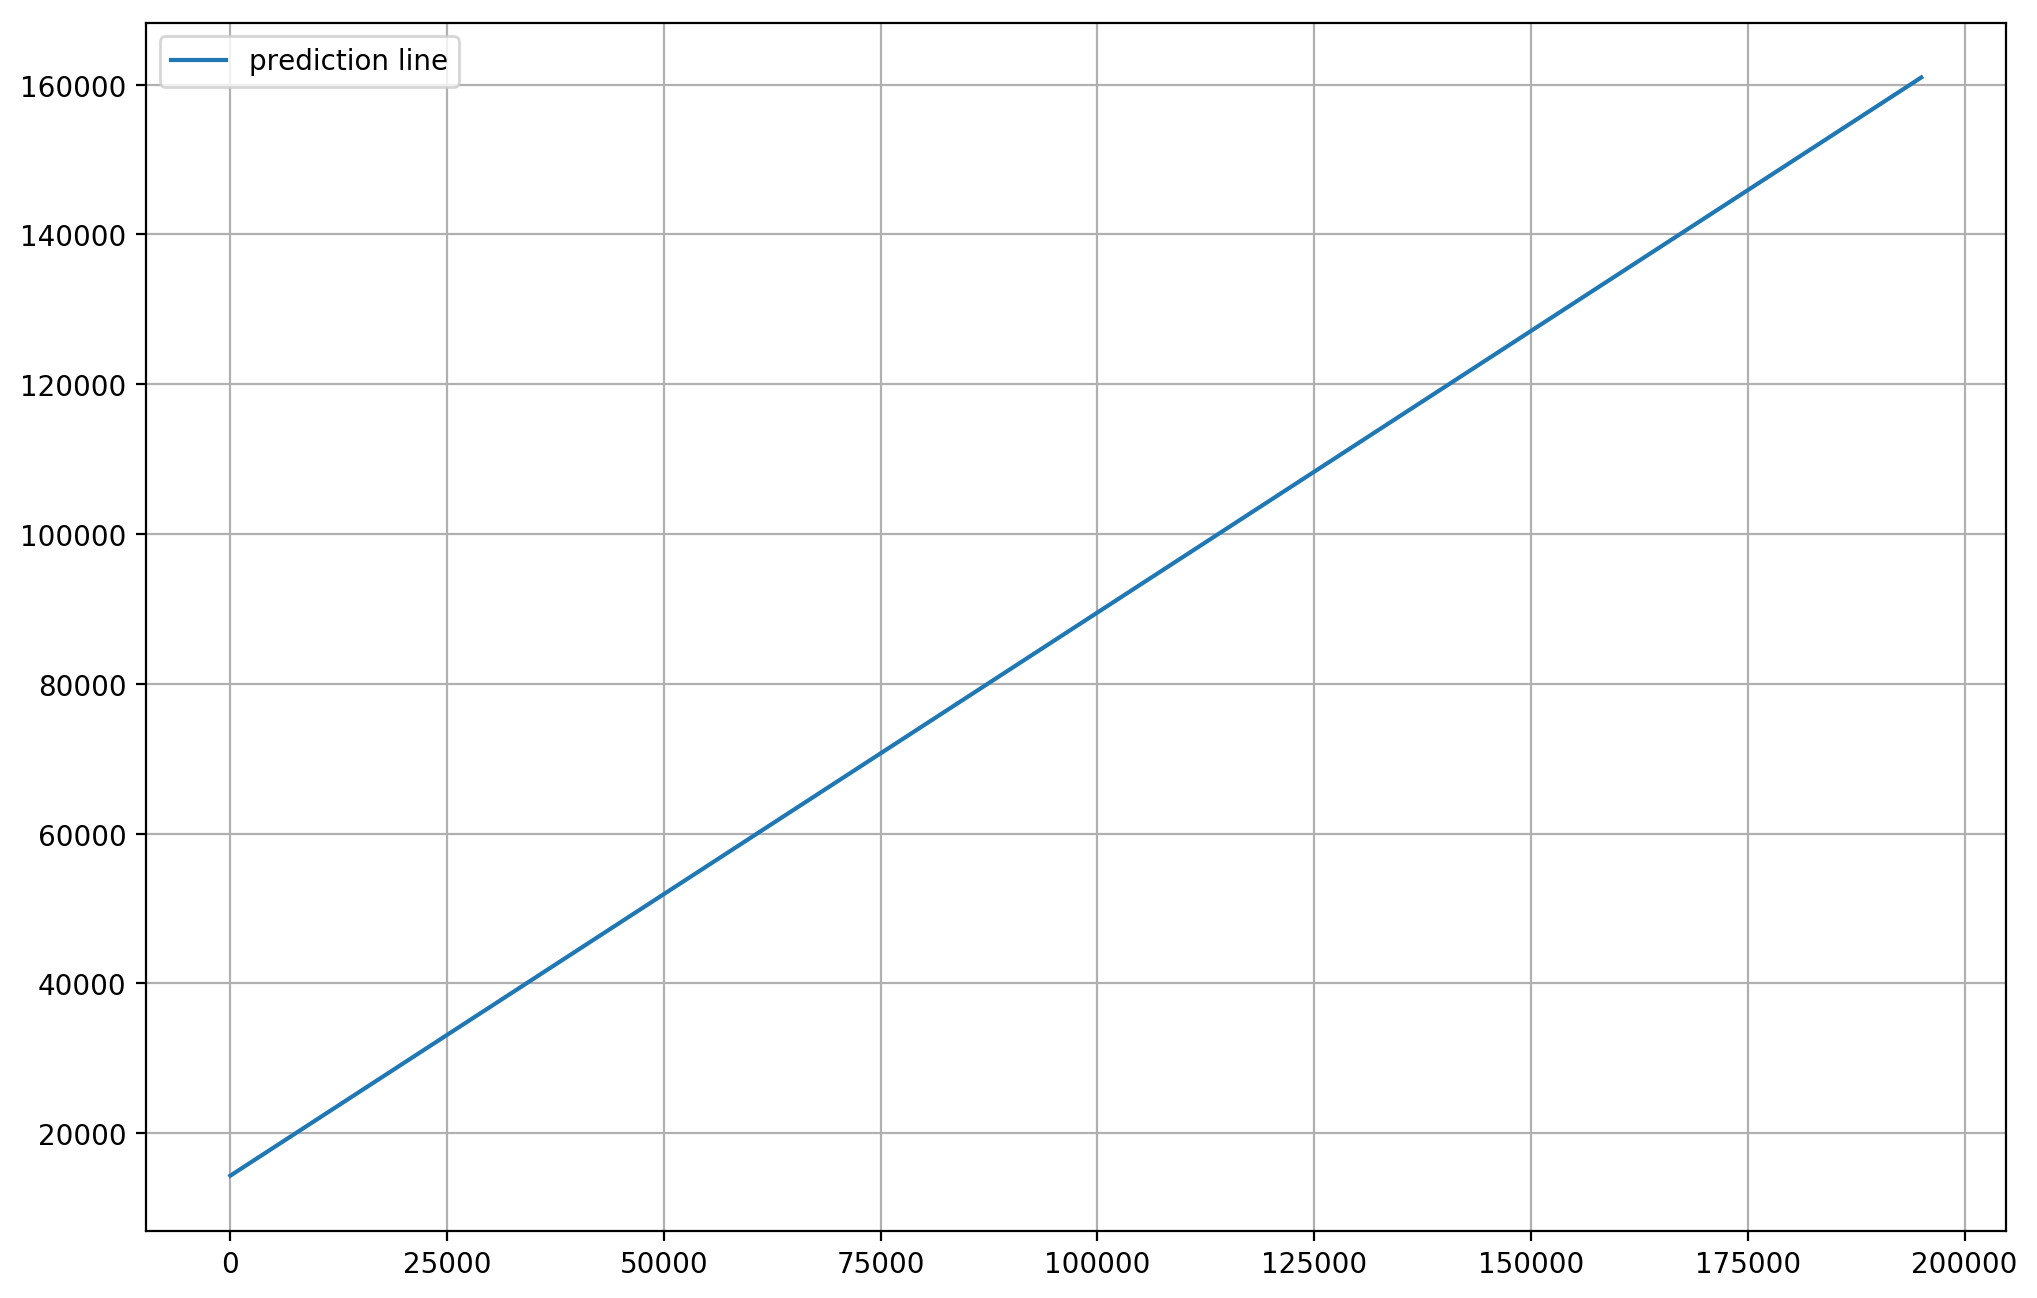

In [21]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test,predictions, 1))(np.unique(y_test)),label='prediction line')
plt.grid(True)
plt.legend(loc='best')